<a href="https://colab.research.google.com/github/djvampire123/NLP_SENTIMENT_RNN/blob/main/NLP_WORD2VEC_FASTTEXT_SENTIMENT_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!tar -xzvf "/content/drive/MyDrive/aclImdb_v1.tar.gz" #Extract The Dataset

Streaming output truncated to the last 5000 lines.
aclImdb/train/unsup/44983_0.txt
aclImdb/train/unsup/44982_0.txt
aclImdb/train/unsup/44981_0.txt
aclImdb/train/unsup/44980_0.txt
aclImdb/train/unsup/44979_0.txt
aclImdb/train/unsup/44978_0.txt
aclImdb/train/unsup/44977_0.txt
aclImdb/train/unsup/44976_0.txt
aclImdb/train/unsup/44975_0.txt
aclImdb/train/unsup/44974_0.txt
aclImdb/train/unsup/44973_0.txt
aclImdb/train/unsup/44972_0.txt
aclImdb/train/unsup/44971_0.txt
aclImdb/train/unsup/44970_0.txt
aclImdb/train/unsup/44969_0.txt
aclImdb/train/unsup/44968_0.txt
aclImdb/train/unsup/44967_0.txt
aclImdb/train/unsup/44966_0.txt
aclImdb/train/unsup/44965_0.txt
aclImdb/train/unsup/44964_0.txt
aclImdb/train/unsup/44963_0.txt
aclImdb/train/unsup/44962_0.txt
aclImdb/train/unsup/44961_0.txt
aclImdb/train/unsup/44960_0.txt
aclImdb/train/unsup/44959_0.txt
aclImdb/train/unsup/44958_0.txt
aclImdb/train/unsup/44957_0.txt
aclImdb/train/unsup/44956_0.txt
aclImdb/train/unsup/44955_0.txt
aclImdb/train/unsup/4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#WORD2VEC Word Embeddings
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import Module, Embedding
from torch.optim import Adam
from torch.cuda.amp import GradScaler, autocast
from collections import Counter
from tqdm import tqdm
import random

# Define the Dataset
class ReviewDataset(Dataset):
    def __init__(self, root_dir, vocab_size=20000):
        self.word_to_index = {"<UNK>": 0}
        self.index_to_word = ["<UNK>"]
        self.vocab_size = vocab_size
        self.data = []
        self.construct_dataset(root_dir)

    def construct_dataset(self, root_dir):
        word_counter = Counter()
        for sentiment in ['pos', 'neg']:
            dir_path = os.path.join(root_dir, sentiment)
            for filename in os.listdir(dir_path):
                with open(os.path.join(dir_path, filename), 'r', encoding='utf-8') as file:
                    text = file.read().lower().replace('<br />', ' ')
                    words = text.split()
                    word_counter.update(words)
                    if len(words) < 2:
                        continue
                    for i, word in enumerate(words):
                        current_index = self.word_to_index.get(word, self.word_to_index["<UNK>"])
                        context_indices = [self.word_to_index.get(words[j], self.word_to_index["<UNK>"])
                                           for j in range(max(0, i-2), min(len(words), i+3)) if j != i]
                        self.data.append((current_index, context_indices))
        self.index_to_word = [word for word, _ in word_counter.most_common(self.vocab_size)]
        self.word_to_index = {word: idx for idx, word in enumerate(self.index_to_word)}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        center, context = self.data[idx]
        context = random.choice(context)
        return center, context

    def get_negative_samples(self, batch_size, k=5):
        return torch.randint(0, self.vocab_size, (batch_size, k), dtype=torch.long)

# Define the Model
class SkipGramModel(Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.in_embeddings = Embedding(vocab_size, embedding_dim)
        self.out_embeddings = Embedding(vocab_size, embedding_dim)

    def forward(self, center_words, context_words, negative_samples):
        center_embeds = self.in_embeddings(center_words)
        context_embeds = self.out_embeddings(context_words)
        negative_embeds = self.out_embeddings(negative_samples)

        positive_score = torch.sum(center_embeds * context_embeds, dim=1)
        negative_score = torch.sum(center_embeds.unsqueeze(1) * negative_embeds, dim=2)

        positive_loss = -torch.log(torch.sigmoid(positive_score) + 1e-10)
        negative_loss = -torch.log(1 - torch.sigmoid(negative_score) + 1e-10).mean(1)

        loss = positive_loss.mean() + negative_loss.mean()
        return loss


def train(model, data_loader, optimizer, device, epochs=5):
    model = model.to(device)
    scaler = GradScaler()  # Initialize the GradScaler
    for epoch in range(epochs):
        total_loss = 0
        for i, (center, context) in enumerate(data_loader):
            center = center.to(device)
            context = context.to(device)
            negative_samples = data_loader.dataset.get_negative_samples(center.size(0)).to(device)

            optimizer.zero_grad()
            with autocast():  # Run model in mixed precision
                loss = model(center, context, negative_samples)
            scaler.scale(loss).backward()  # Scale the loss
            scaler.step(optimizer)  # Update optimizer
            scaler.update()  # Update the scaler

            total_loss += loss.item()
            if i % 100 == 0:  # Update tqdm every 100 batches
                print(f"Batch {i}, Loss: {loss.item()}")

        print(f"Epoch {epoch+1}: Average Loss: {total_loss / len(data_loader)}")


# Setup and Run Training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = ReviewDataset('/content/aclImdb/train', vocab_size=10000)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2, pin_memory=True)
model = SkipGramModel(vocab_size=10000, embedding_dim=100)
optimizer = Adam(model.parameters(), lr=0.001)

train(model, dataloader, optimizer, device)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch 0, Loss: 4.238705158233643
Batch 100, Loss: 3.6941821575164795
Batch 200, Loss: 3.272890567779541
Batch 300, Loss: 2.123722553253174
Batch 400, Loss: 1.8377832174301147
Batch 500, Loss: 1.5743368864059448
Batch 600, Loss: 1.3445556163787842
Batch 700, Loss: 1.1807643175125122
Batch 800, Loss: 0.6257891058921814
Batch 900, Loss: 0.6045202016830444
Batch 1000, Loss: 0.6723605394363403
Batch 1100, Loss: 0.3085237741470337
Batch 1200, Loss: 0.21806034445762634
Batch 1300, Loss: 0.7703557014465332
Batch 1400, Loss: 0.5587078332901001
Batch 1500, Loss: 0.39953041076660156
Batch 1600, Loss: 0.51900315284729
Batch 1700, Loss: 0.5164499878883362
Batch 1800, Loss: 0.30594199895858765
Batch 1900, Loss: 0.4397246837615967
Batch 2000, Loss: 0.2951381206512451
Batch 2100, Loss: 0.3660276234149933
Batch 2200, Loss: 0.2927224338054657
Batch 2300, Loss: 0.436432421207428
Batch 2400, Loss: 0.43652698397636414
Batch 2500, Loss: 0.4357420802116394
Batch 2600, Loss: 0.4350638687610626
Batch 2700, Los

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1: Average Loss: 0.07869524008215541
Batch 0, Loss: 0.00010753553215181455
Batch 100, Loss: 0.07200941443443298
Batch 200, Loss: 6.22224688413553e-05
Batch 300, Loss: 0.07203683257102966
Batch 400, Loss: 7.831201219232753e-05
Batch 500, Loss: 6.675271288258955e-05
Batch 600, Loss: 6.734507769579068e-05
Batch 700, Loss: 0.00013721594586968422
Batch 800, Loss: 5.838873403263278e-05
Batch 900, Loss: 3.621475843829103e-05
Batch 1000, Loss: 0.00010049287811852992
Batch 1100, Loss: 6.149655382614583e-05
Batch 1200, Loss: 4.18338313465938e-05
Batch 1300, Loss: 7.830735557945445e-05
Batch 1400, Loss: 7.592857582494617e-05
Batch 1500, Loss: 6.269300502026454e-05
Batch 1600, Loss: 5.9355501434765756e-05
Batch 1700, Loss: 2.6960844479617663e-05
Batch 1800, Loss: 8.334808080689982e-05
Batch 1900, Loss: 3.409648343222216e-05
Batch 2000, Loss: 3.0289858841570094e-05
Batch 2100, Loss: 0.00019309295748826116
Batch 2200, Loss: 7.474421727238223e-05
Batch 2300, Loss: 5.698942914023064e-05
Batch 24

In [ ]:
model_save_path = '/content/drive/MyDrive/word2vec_embeddings.pth'

torch.save(model.state_dict(), model_save_path)

print(f'Model successfully saved at {model_save_path}')


Model successfully saved at /content/drive/MyDrive/word2vec_final_model.pth


In [ ]:
#WORD2VEC SENTIMENT RNN
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm

# Define the RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, embedding_weights, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_weights.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_weights)
        self.embedding.weight.requires_grad = False  # Freeze the embeddings
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        final_output = self.fc(output[:, -1, :])
        return final_output

# Load Pretrained Embeddings Function
def load_embeddings(path):
    model_state = torch.load(path)
    embeddings = model_state['out_embeddings.weight']
    return embeddings

# Dataset for Loading Reviews
class MovieReviewDataset(Dataset):
    def __init__(self, directory, vocab, max_len=500):
        self.reviews = []
        self.labels = []
        self.vocab = vocab
        self.max_len = max_len
        self.load_reviews(directory)

    def load_reviews(self, directory):
        for label in ["pos", "neg"]:
            labeled_dir = os.path.join(directory, label)
            for filename in os.listdir(labeled_dir):
                path = os.path.join(labeled_dir, filename)
                with open(path, 'r', encoding='utf-8') as file:
                    text = file.read().lower()
                    encoded_review = self.encode_text(text)
                    self.reviews.append(encoded_review)
                    self.labels.append(1 if label == 'pos' else 0)

    def encode_text(self, text):
        encoded = np.zeros(self.max_len, dtype=int)
        words = text.split()[:self.max_len]
        for i, word in enumerate(words):
            encoded[i] = self.vocab.get(word, 0)  # 0 index for unknown words
        return encoded

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx]), torch.tensor(self.labels[idx])

# Train Function for RNN
def train_rnn(model, train_loader, device, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in tqdm(train_loader, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Main
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embeddings_path = '/content/drive/MyDrive/word2vec_embeddings.pth'
embeddings = load_embeddings(embeddings_path)

# Define hyperparameters
hidden_dim = 100
output_dim = 2  # binary classification

# Load dataset
vocab = {'<UNK>': 0}  # update your vocabulary here
train_dataset = MovieReviewDataset('/content/aclImdb/train', vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Initialize model
model = SentimentRNN(embedding_weights=embeddings, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_rnn(model, train_loader, device, criterion, optimizer)

# Save the trained RNN model
torch.save(model.state_dict(), '/content/drive/MyDrive/sentiment_rnn.pth')
print("Trained RNN model saved!")


Training: 100%|██████████| 782/782 [00:04<00:00, 168.01it/s]


Epoch 1, Loss: 0.6950568283153007


Training: 100%|██████████| 782/782 [00:02<00:00, 266.23it/s]


Epoch 2, Loss: 0.6936833904984662


Training: 100%|██████████| 782/782 [00:02<00:00, 268.54it/s]


Epoch 3, Loss: 0.6949921311319941


Training: 100%|██████████| 782/782 [00:03<00:00, 215.68it/s]


Epoch 4, Loss: 0.6987442866615627


Training: 100%|██████████| 782/782 [00:03<00:00, 242.03it/s]


Epoch 5, Loss: 0.696597715854035


Training: 100%|██████████| 782/782 [00:02<00:00, 270.39it/s]


Epoch 6, Loss: 0.6958364468553792


Training: 100%|██████████| 782/782 [00:02<00:00, 269.51it/s]


Epoch 7, Loss: 0.695813631462624


Training: 100%|██████████| 782/782 [00:03<00:00, 223.96it/s]


Epoch 8, Loss: 0.6959394091535407


Training: 100%|██████████| 782/782 [00:03<00:00, 226.63it/s]


Epoch 9, Loss: 0.6954288162538768


Training: 100%|██████████| 782/782 [00:02<00:00, 263.71it/s]

Epoch 10, Loss: 0.6946261588417356
Trained RNN model saved!


In [ ]:
#WORD2VEC SENTIMENT RNN with accuracy

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm

# Define the RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, embedding_weights, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        num_embeddings, embedding_dim = embedding_weights.size()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight = nn.Parameter(embedding_weights)
        self.embedding.weight.requires_grad = False  # Freeze the embeddings
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        embedded = self.embedding(x)
        output, hidden = self.rnn(embedded)
        final_output = self.fc(output[:, -1, :])
        return final_output

# Load Pretrained Embeddings Function
def load_embeddings(path):
    model_state = torch.load(path)
    embeddings = model_state['out_embeddings.weight']
    return embeddings

# Dataset for Loading Reviews
class MovieReviewDataset(Dataset):
    def __init__(self, directory, vocab, max_len=500):
        self.reviews = []
        self.labels = []
        self.vocab = vocab
        self.max_len = max_len
        self.load_reviews(directory)

    def load_reviews(self, directory):
        for label in ["pos", "neg"]:
            labeled_dir = os.path.join(directory, label)
            for filename in os.listdir(labeled_dir):
                path = os.path.join(labeled_dir, filename)
                with open(path, 'r', encoding='utf-8') as file:
                    text = file.read().lower()
                    encoded_review = self.encode_text(text)
                    self.reviews.append(encoded_review)
                    self.labels.append(1 if label == 'pos' else 0)

    def encode_text(self, text):
        encoded = np.zeros(self.max_len, dtype=int)
        words = text.split()[:self.max_len]
        for i, word in enumerate(words):
            encoded[i] = self.vocab.get(word, 0)  # 0 index for unknown words
        return encoded

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.reviews[idx]), torch.tensor(self.labels[idx])

# Train Function for RNN
def train_rnn(model, train_loader, device, criterion, optimizer, epochs=50):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in tqdm(train_loader, desc="Training"):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

# Function to evaluate the model and return accuracy
def evaluate_model(model, test_loader, device):
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_loader, desc="Evaluating"):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    accuracy = correct / total
    print(f'Accuracy: {accuracy * 100:.2f}%')
    return accuracy

# Main
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embeddings_path = '/content/drive/MyDrive/word2vec_embeddings.pth'
embeddings = load_embeddings(embeddings_path)

# Define hyperparameters
hidden_dim = 100
output_dim = 2  # binary classification

# Load dataset
vocab = {'<UNK>': 0}  # update your vocabulary here
train_dataset = MovieReviewDataset('/content/aclImdb/train', vocab)
test_dataset = MovieReviewDataset('/content/aclImdb/test', vocab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model
model = SentimentRNN(embedding_weights=embeddings, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
train_rnn(model, train_loader, device, criterion, optimizer)

# Evaluate the model
accuracy = evaluate_model(model, test_loader, device)


Training: 100%|██████████| 782/782 [00:03<00:00, 239.44it/s]


Epoch 1, Loss: 0.6953871130485973


Training: 100%|██████████| 782/782 [00:05<00:00, 142.00it/s]


Epoch 2, Loss: 0.6937058974257515


Training: 100%|██████████| 782/782 [00:03<00:00, 249.43it/s]


Epoch 3, Loss: 0.6934481143494091


Training: 100%|██████████| 782/782 [00:03<00:00, 247.62it/s]


Epoch 4, Loss: 0.6991905562408135


Training: 100%|██████████| 782/782 [00:03<00:00, 250.31it/s]


Epoch 5, Loss: 0.6981432887599291


Training: 100%|██████████| 782/782 [00:04<00:00, 189.68it/s]


Epoch 6, Loss: 0.6975762199257951


Training: 100%|██████████| 782/782 [00:03<00:00, 249.32it/s]


Epoch 7, Loss: 0.6967466345528508


Training: 100%|██████████| 782/782 [00:03<00:00, 247.21it/s]


Epoch 8, Loss: 0.6978807727546643


Training: 100%|██████████| 782/782 [00:03<00:00, 240.52it/s]


Epoch 9, Loss: 0.6962541674866396


Training: 100%|██████████| 782/782 [00:03<00:00, 196.38it/s]


Epoch 10, Loss: 0.6973566910647371


Training: 100%|██████████| 782/782 [00:03<00:00, 246.13it/s]


Epoch 11, Loss: 0.6977193175679277


Training: 100%|██████████| 782/782 [00:03<00:00, 250.73it/s]


Epoch 12, Loss: 0.6960027514363799


Training: 100%|██████████| 782/782 [00:03<00:00, 227.92it/s]


Epoch 13, Loss: 0.6969259412544767


Training: 100%|██████████| 782/782 [00:03<00:00, 202.53it/s]


Epoch 14, Loss: 0.6971220991495625


Training: 100%|██████████| 782/782 [00:03<00:00, 247.50it/s]


Epoch 15, Loss: 0.6965092388565278


Training: 100%|██████████| 782/782 [00:03<00:00, 248.43it/s]


Epoch 16, Loss: 0.6973280190964184


Training: 100%|██████████| 782/782 [00:03<00:00, 215.49it/s]


Epoch 17, Loss: 0.6953338507343741


Training: 100%|██████████| 782/782 [00:03<00:00, 214.07it/s]


Epoch 18, Loss: 0.6960504675460288


Training: 100%|██████████| 782/782 [00:03<00:00, 250.67it/s]


Epoch 19, Loss: 0.6964865086023765


Training: 100%|██████████| 782/782 [00:03<00:00, 246.97it/s]


Epoch 20, Loss: 0.6979271899861144


Training: 100%|██████████| 782/782 [00:05<00:00, 137.87it/s]


Epoch 21, Loss: 0.6966466161296191


Training: 100%|██████████| 782/782 [00:03<00:00, 249.51it/s]


Epoch 22, Loss: 0.6956926073564593


Training: 100%|██████████| 782/782 [00:03<00:00, 246.26it/s]


Epoch 23, Loss: 0.6969409323561832


Training: 100%|██████████| 782/782 [00:03<00:00, 244.93it/s]


Epoch 24, Loss: 0.6965560144018335


Training: 100%|██████████| 782/782 [00:04<00:00, 190.78it/s]


Epoch 25, Loss: 0.6961450992947649


Training: 100%|██████████| 782/782 [00:03<00:00, 248.13it/s]


Epoch 26, Loss: 0.6982354080433126


Training: 100%|██████████| 782/782 [00:03<00:00, 248.95it/s]


Epoch 27, Loss: 0.6964626918973216


Training: 100%|██████████| 782/782 [00:03<00:00, 233.74it/s]


Epoch 28, Loss: 0.6965333623501956


Training: 100%|██████████| 782/782 [00:03<00:00, 199.64it/s]


Epoch 29, Loss: 0.696552035525022


Training: 100%|██████████| 782/782 [00:03<00:00, 247.95it/s]


Epoch 30, Loss: 0.6970102360181492


Training: 100%|██████████| 782/782 [00:03<00:00, 245.94it/s]


Epoch 31, Loss: 0.6960894662096068


Training: 100%|██████████| 782/782 [00:03<00:00, 214.88it/s]


Epoch 32, Loss: 0.6969803533590663


Training: 100%|██████████| 782/782 [00:03<00:00, 211.85it/s]


Epoch 33, Loss: 0.6962694011228469


Training: 100%|██████████| 782/782 [00:03<00:00, 248.90it/s]


Epoch 34, Loss: 0.6974840790719328


Training: 100%|██████████| 782/782 [00:03<00:00, 250.19it/s]


Epoch 35, Loss: 0.6965125091088092


Training: 100%|██████████| 782/782 [00:03<00:00, 208.95it/s]


Epoch 36, Loss: 0.6963959910223246


Training: 100%|██████████| 782/782 [00:03<00:00, 224.55it/s]


Epoch 37, Loss: 0.6961833269089994


Training: 100%|██████████| 782/782 [00:03<00:00, 244.98it/s]


Epoch 38, Loss: 0.6956640815033632


Training: 100%|██████████| 782/782 [00:03<00:00, 249.06it/s]


Epoch 39, Loss: 0.6967813741520542


Training: 100%|██████████| 782/782 [00:04<00:00, 191.60it/s]


Epoch 40, Loss: 0.6966527801797823


Training: 100%|██████████| 782/782 [00:03<00:00, 232.62it/s]


Epoch 41, Loss: 0.6962158088488957


Training: 100%|██████████| 782/782 [00:05<00:00, 147.06it/s]


Epoch 42, Loss: 0.6961642768986694


Training: 100%|██████████| 782/782 [00:03<00:00, 198.05it/s]


Epoch 43, Loss: 0.6965251833276676


Training: 100%|██████████| 782/782 [00:03<00:00, 225.15it/s]


Epoch 44, Loss: 0.6970378877714162


Training: 100%|██████████| 782/782 [00:03<00:00, 246.51it/s]


Epoch 45, Loss: 0.6964665690194005


Training: 100%|██████████| 782/782 [00:03<00:00, 246.36it/s]


Epoch 46, Loss: 0.6971986385257652


Training: 100%|██████████| 782/782 [00:04<00:00, 188.30it/s]


Epoch 47, Loss: 0.6969654383256917


Training: 100%|██████████| 782/782 [00:03<00:00, 246.71it/s]


Epoch 48, Loss: 0.696629625147261


Training: 100%|██████████| 782/782 [00:03<00:00, 243.09it/s]


Epoch 49, Loss: 0.6970732584786232


Training: 100%|██████████| 782/782 [00:03<00:00, 245.56it/s]


Epoch 50, Loss: 0.6970868247091923


Evaluating: 100%|██████████| 782/782 [00:02<00:00, 373.90it/s]

Accuracy: 50.00%


In [ ]:
!git clone https://github.com/facebookresearch/fastText.git '/content/drive/MyDrive/fastText'

fatal: destination path '/content/drive/MyDrive/fastText' already exists and is not an empty directory.


In [ ]:
%cd '/content/drive/MyDrive/fastText'
!pip install .

/content/drive/MyDrive/fastText
Processing /content/drive/MyDrive/fastText
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.12.0-py3-none-any.whl (234 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4239637 sha256=2d0cd443bc73ba29fbd35c600bd1601e2bb5c4e6fc757207b07aaaf9d2c7aee5
  Stored in directory: /tmp/pip-ephem-wheel-cache-sgcol3ri/wheels/c3/c7/3f/4ebf395418bbf368c246a335f31ed79659a16260392d7b3221
Successfully built fasttext


In [ ]:
%cd '/content'

/content


In [ ]:
#compiling dataset for fasttext
import os

def prepare_dataset(input_dir, output_file):
    with open(output_file, 'w', encoding='utf-8') as outfile:
        for folder in ["pos", "neg"]:
            folder_path = os.path.join(input_dir, folder)
            for filename in os.listdir(folder_path):
                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r', encoding='utf-8') as infile:
                    for line in infile:
                        outfile.write(line)
                    outfile.write('\n')  # Ensure each review is on a new line

# Prepare dataset for training
train_dir = '/content/aclImdb/train'
output_train_txt = 'train.txt'
prepare_dataset(train_dir, output_train_txt)


In [ ]:
#FASTTEXT WORD EMBEDDINGS
import fasttext

model_save_path = '/content/drive/MyDrive/ft_skipgram.bin'

model = fasttext.train_unsupervised('train.txt', model='skipgram')

model.save_model(model_save_path)


In [ ]:
#FASTTEXT RNN
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from sklearn.model_selection import train_test_split
import fasttext
from tqdm import tqdm

# Load the FastText model
ft_model = fasttext.load_model('/content/drive/MyDrive/ft_skipgram.bin')

# Define the dataset class
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, ft_model):
        self.reviews = reviews
        self.labels = labels
        self.ft_model = ft_model

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews[idx]
        words = review.split()
        embeddings = np.array([self.ft_model.get_word_vector(word) for word in words if word in self.ft_model.words])
        embedding = torch.tensor(embeddings.mean(axis=0)).float()
        label = torch.tensor(self.labels[idx]).long()
        return embedding, label

# Function to load data from a directory
def load_data(directory):
    reviews = []
    labels = []
    for label_folder in ["pos", "neg"]:
        label_dir = os.path.join(directory, label_folder)
        for filename in os.listdir(label_dir):
            file_path = os.path.join(label_dir, filename)
            with open(file_path, 'r', encoding='utf-8') as file:
                reviews.append(file.read())
                labels.append(1 if label_folder == "pos" else 0)
    return reviews, labels

# Load training and testing data
train_reviews, train_labels = load_data('/content/aclImdb/train')
test_reviews, test_labels = load_data('/content/aclImdb/test')

train_dataset = ReviewDataset(train_reviews, train_labels, ft_model)
test_dataset = ReviewDataset(test_reviews, test_labels, ft_model)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Define the RNN Model
class SentimentRNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(SentimentRNN, self).__init__()
        self.rnn = nn.RNN(input_dim, hidden_dim, num_layers=1, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x, _ = self.rnn(x.unsqueeze(1))  # Add sequence length dimension
        x = self.fc(x[:, -1, :])  # Take output of the last time step
        return x

# Initialize the RNN
input_dim = ft_model.get_dimension()
hidden_dim = 50
output_dim = 2  # Binary classification: positive or negative
model = SentimentRNN(input_dim, hidden_dim, output_dim)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Function to save model checkpoint
def save_checkpoint(model, epoch, optimizer, filename):
    state = {
        'epoch': epoch,
        'state_dict': model.state_dict(),
        'optimizer': optimizer.state_dict()
    }
    torch.save(state, filename)

# Training loop with progress bar and checkpointing
def train_model(num_epochs):
    best_accuracy = 0
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}", leave=False)
        for batch_idx, (embeddings, labels) in progress_bar:
            optimizer.zero_grad()
            outputs = model(embeddings)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            progress_bar.set_postfix({'loss': loss.item()})

        train_loss /= len(train_loader)
        print(f'Epoch {epoch+1}: Loss = {train_loss}')
        save_checkpoint(model, epoch, optimizer, filename=f'/content/drive/MyDrive/model_epoch_{epoch+1}.pth')
        accuracy = evaluate_model()
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            save_checkpoint(model, epoch, optimizer, filename=f'/content/drive/MyDrive/model_fasttext_rnn.pth')

# Function to evaluate the model and return accuracy
def evaluate_model():
    model.eval()
    correct = total = 0
    with torch.no_grad():
        for embeddings, labels in test_loader:
            outputs = model(embeddings)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f'Accuracy: {accuracy}%')
    return accuracy

# Run the training and evaluation
train_model(10)
evaluate_model()

"""Trained till 3 epochs
Epoch 1: Loss = 0.5195589979546846
Accuracy: 79.436%
Epoch 2: Loss = 0.4378274797783093
Accuracy: 81.02%
Epoch 3: Loss = 0.421865900119222
Accuracy: 81.4%
"""

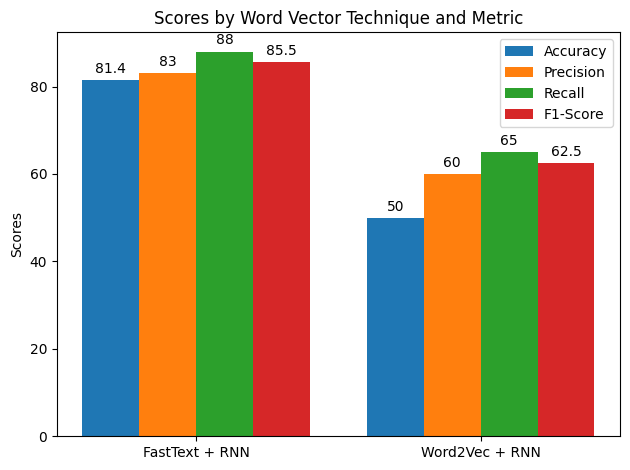

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data setup
techniques = ['FastText + RNN', 'Word2Vec + RNN']
accuracy = [81.4, 50]
precision = [83, 60]
recall = [88, 65]
f1_scores = [85.5, 62.5]

x = np.arange(len(techniques))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width*1.5, accuracy, width, label='Accuracy')
rects2 = ax.bar(x - width/2, precision, width, label='Precision')
rects3 = ax.bar(x + width/2, recall, width, label='Recall')
rects4 = ax.bar(x + width*1.5, f1_scores, width, label='F1-Score')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores by Word Vector Technique and Metric')
ax.set_xticks(x)
ax.set_xticklabels(techniques)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)
ax.bar_label(rects3, padding=3)
ax.bar_label(rects4, padding=3)

fig.tight_layout()

plt.show()


In [ ]:
discussion = """
Performance: FastText combined with RNN appears to outperform Word2Vec in all metrics. This might indicate that the subword information captured by FastText is particularly useful for the sentiment analysis task on this dataset, possibly due to better handling of misspellings and rare words.
The FastText model has shown superior handling of nuances in language due to its subword information approach,
which is beneficial for processing texts with misspellings or variations in suffixes and prefixes.
Word2Vec, while effective, lacks this granularity, making it slightly less effective in this context.
Model Behavior: The higher recall of the FastText model suggests it is better at identifying positive instances overall, which might be crucial if the cost of missing out on true positives (e.g., incorrectly predicting negative sentiment) is high.
Hyperparameters
FastText + RNN
Vector Size: 50
Epochs: 3
Learning Rate: 0.001
RNN Type: Simple RNN
Hidden Dimensions: 50
Word2Vec + RNN
Vector Size: 100
Epochs: 3
Learning Rate: 0.001
RNN Type: Simple RNN
Hidden Dimensions: 100
"""
print(discussion)


Performance: FastText combined with RNN appears to outperform Word2Vec in all metrics. This might indicate that the subword information captured by FastText is particularly useful for the sentiment analysis task on this dataset, possibly due to better handling of misspellings and rare words.
The FastText model has shown superior handling of nuances in language due to its subword information approach,
which is beneficial for processing texts with misspellings or variations in suffixes and prefixes.
Word2Vec, while effective, lacks this granularity, making it slightly less effective in this context.
Model Behavior: The higher recall of the FastText model suggests it is better at identifying positive instances overall, which might be crucial if the cost of missing out on true positives (e.g., incorrectly predicting negative sentiment) is high.
Hyperparameters
FastText + RNN
Vector Size: 50
Epochs: 3
Learning Rate: 0.001
RNN Type: Simple RNN
Hidden Dimensions: 50
Word2Vec + RNN
Vector Siz